# Region-Based Image Segmentation
## Active Contours/Snakes Segmentation

## 1. Introduction to Active Contours

**Active Contours** (also called **Snakes**) are energy-minimizing curves used for image segmentation. They deform to fit object boundaries by balancing two competing forces:

- **Internal Energy**: Keeps the contour smooth and continuous
- **External Energy**: Pulls the contour toward image edges (high gradients)

### Why Active Contours?
- Can segment objects with complex shapes
- Provides smooth, continuous boundaries
- Works well for medical imaging (cells, organs)
- Allows manual initialization (user control)

### The Energy Function:
The snake minimizes total energy:

**E_total = E_internal + E_external**

Where:
- **E_internal = α·E_elasticity + β·E_curvature** (smoothness constraints)
- **E_external** = attraction to edges (high gradient regions)

The contour iteratively moves to find the position where total energy is minimized.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.io import imread
from skimage.segmentation import active_contour
from skimage.filters import gaussian


## 2. Load Test Image

We will use a cell image to demonstrate active contour segmentation. The cell has:
- A bright interior (high intensity)
- A dark boundary ring (sharp gradient)
- Clear edges for the snake to detect

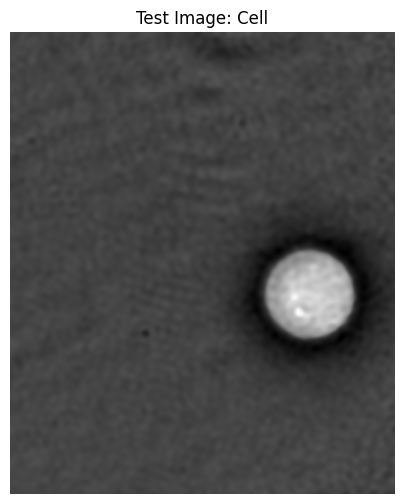

In [36]:
# Load Test Image
from skimage import data

# Load single cell image
img = data.cell()

# Display single cell image
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.title('Test Image: Cell')
plt.axis('off')
plt.show()

## 3. Grayscale Conversion

Active contours work on grayscale images. We check if conversion is needed:
- **Color images** (3 channels: RGB) → convert to grayscale
- **Grayscale images** (1 channel) → use as-is

Grayscale conversion uses perceptual weights:
**Gray = 0.2125×R + 0.7154×G + 0.0721×B**

Image is already grayscale


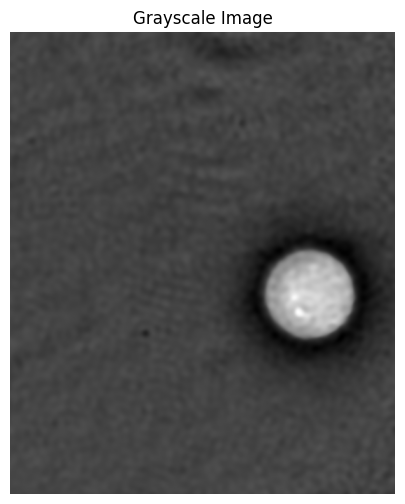

In [37]:
# Convert to Grayscale (if needed)

if len(img.shape) == 3:
    img_gray = color.rgb2gray(img)
    print("Converted from color to grayscale")
else:
    img_gray = img
    print("Image is already grayscale")

plt.figure(figsize=(6, 6))
plt.imshow(img_gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()

## 4. Image Smoothing

**Why smooth?** Raw images contain noise (random pixel variations) that can interfere with edge detection.

**Gaussian smoothing:**
- Reduces noise by averaging each pixel with its neighbors
- Uses a bell-curve (Gaussian) kernel
- Parameter **σ (sigma)** controls smoothing strength:
  - Low σ: Light smoothing (preserves detail)
  - High σ: Heavy smoothing (removes noise but blurs edges)

**Benefits for active contours:**
- Snake finds real edges, not noise
- Smoother convergence
- More stable results

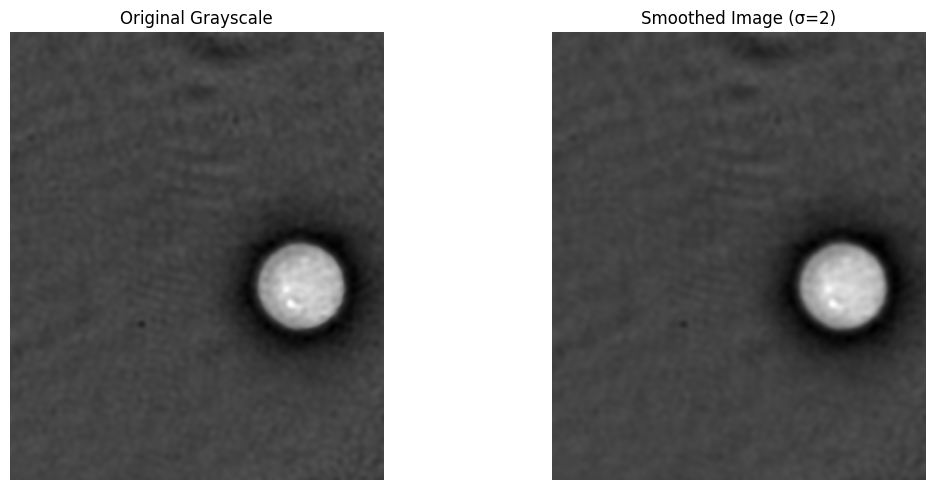

Image smoothened succesfully


In [39]:
# Smoothen the Image

img_smooth = gaussian(img_gray, sigma=2, preserve_range=True)

fig, axes = plt.subplots(1, 2, figsize =(12, 5))

axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title('Original Grayscale')
axes[0].axis('off')

axes[1].imshow(img_smooth, cmap='gray')
axes[1].set_title('Smoothed Image (σ=2)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("Image smoothened succesfully")

## 5. Define Initial Contour

The snake needs a **starting position** near the target object. We create a circular contour using:

**Circle equation:**
- x = center_x + radius × cos(θ)
- y = center_y + radius × sin(θ)

Where θ ranges from 0 to 2π (full circle).

**Key points:**
- Initial contour should be **roughly around** the object
- Doesn't need to be perfect - the snake will adjust!
- Position is more important than exact size

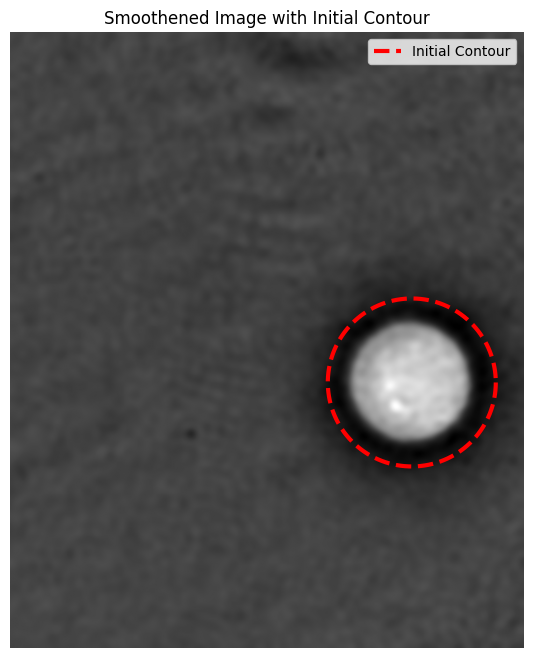

Initial contour created with 400 points
Center: (375, 430)
Radius: 90 pixels


In [63]:
# Define Initial Contour - Draw a circle around the image

def create_circular_contour(center_row, center_col, radius, num_points=400):
    angles = np.linspace(0, 2*np.pi, num_points)
    row_coords = center_row + radius * np.sin(angles)
    col_coords = center_col + radius * np.cos(angles)

    return np.array([row_coords, col_coords]).T

img_height, img_width = img_smooth.shape
center_row = 375
center_col = 430
radius = 90

initial_contour = create_circular_contour(center_row, center_col, radius)

plt.figure(figsize=(8,8))
plt.imshow(img_smooth, cmap='gray')
plt.plot(initial_contour[:, 1], initial_contour[:, 0], '--r', linewidth=3, label='Initial Contour')
plt.title('Smoothened Image with Initial Contour')
plt.legend(loc='upper right')
plt.axis('off')
plt.show()

print(f"Initial contour created with {len(initial_contour)} points")
print(f"Center: ({center_row}, {center_col})")
print(f"Radius: {radius} pixels")



## 6. Run Active Contour Algorithm (Energy Minimization)

This is where the snake evolves to fit the cell boundary!

### The Algorithm:
1. Start with initial contour
2. At each iteration:
   - Calculate internal energy (smoothness, curvature)
   - Calculate external energy (distance to edges/gradients)
   - Compute total energy = internal + external
   - Move each point slightly to **reduce total energy**
3. Repeat until convergence (energy stops decreasing)

### Key Parameters:

**Internal Energy (Smoothness Constraints):**
- **α (alpha)**: Elasticity - controls stretching
  - Low → flexible, fits tight details
  - High → smooth, resists stretching
- **β (beta)**: Rigidity - controls bending
  - Low → can make sharp corners
  - High → prefers smooth curves

**External Energy (Edge Attraction):**
- **w_edge**: Weight for edge attraction (pulls toward high gradients)
- **w_line**: Weight for line attraction (not used here)

**Convergence:**
- **γ (gamma)**: Step size (how fast contour moves)
- **max_num_iter**: Maximum iterations
- **convergence**: Stops when change < threshold

### The Minimization Process:
The contour finds the position where:
- ✓ It's smooth (low internal energy)
- ✓ It sits on edges (low external energy)  
- ✓ **Total energy is MINIMIZED**

In [59]:
# Apply Active Contour Segmentation(Evolve Iteratively)
# Energy Minimization

snake =  active_contour(
    img_smooth,
    initial_contour,
    alpha=0.015,
    beta=10,
    gamma=0.001,
    w_line=0,
    w_edge=1,
    max_num_iter=2500,
    convergence=0.1
)

print("Active contour algorithm completed!")
print(f"Initial contour had {len(initial_contour)} points")
print(f"Final snake has {len(snake)} points")


Active contour algorithm completed!
Initial contour had 400 points
Final snake has 400 points


## 7. Results: Visualizing the Snake Evolution

Now we see the result of energy minimization

**What to look for:**
- **Red dashed line**: Initial contour (starting position)
- **Blue solid line**: Final snake (converged position)

The snake moved from the rough circle to precisely fit the cell boundary by:
1. Detecting edges (high gradient regions)
2. Balancing smoothness with edge-fitting
3. Converging to the energy minimum

**This demonstrates:**
- The snake successfully identified the cell boundary
- Internal energy kept the contour smooth
- External energy pulled it toward edges
- The combination minimized total energy

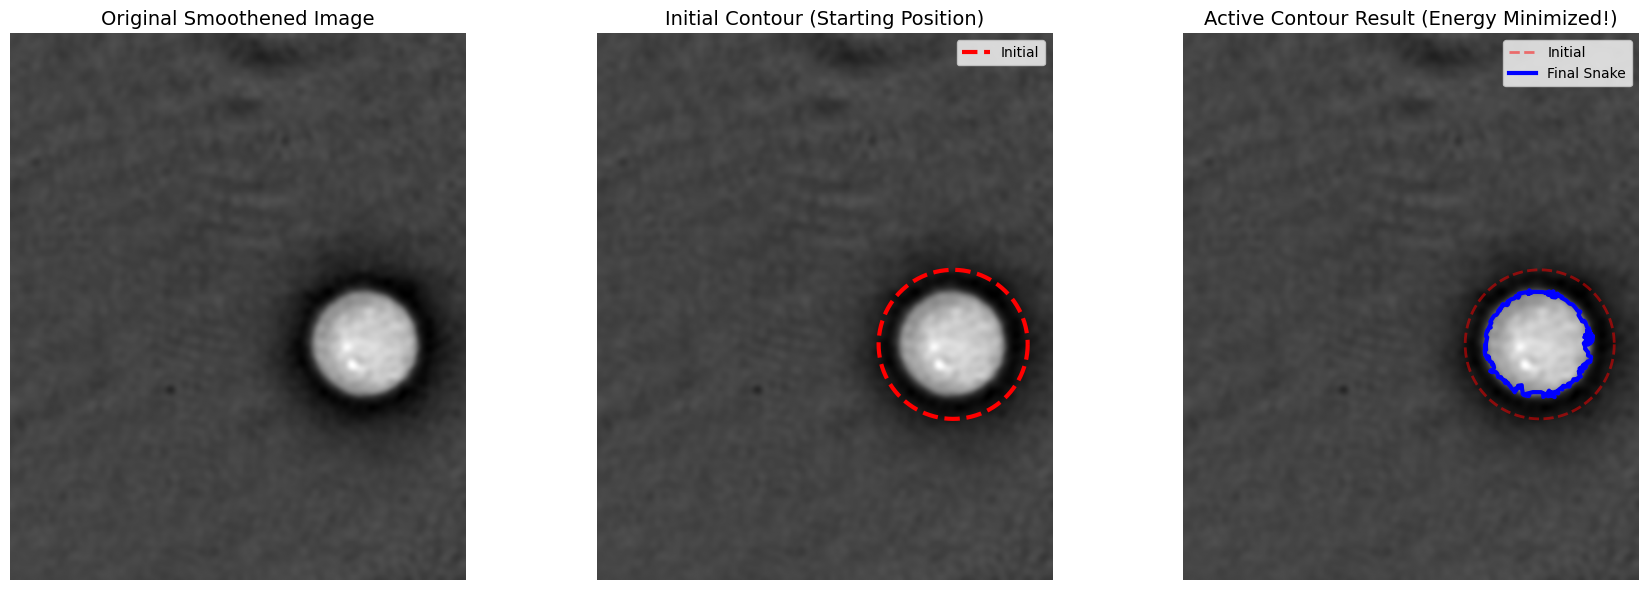

In [64]:
# Visualize Results - Initial vs Final Contour

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original Image
axes[0].imshow(img_smooth, cmap='gray')
axes[0].set_title('Original Smoothened Image', fontsize=14)
axes[0].axis('off')

#Initial Contour
axes[1].imshow(img_smooth, cmap='gray')
axes[1].plot(initial_contour[:, 1], initial_contour[:, 0], '--r', lw=3, label='Initial')
axes[1].set_title('Initial Contour (Starting Position)', fontsize=14)
axes[1].legend(loc='upper right')
axes[1].axis('off')

# Final snake(after energy minimization)
axes[2].imshow(img_smooth, cmap='gray')
axes[2].plot(initial_contour[:, 1], initial_contour[:, 0], '--r', lw=2, alpha=0.5, label='Initial')
axes[2].plot(snake[:, 1], snake[:, 0], '-b', lw=3, label='Final Snake')
axes[2].set_title('Active Contour Result (Energy Minimized!)', fontsize=14)
axes[2].legend(loc='upper right')
axes[2].axis('off')

plt.tight_layout()
plt.show()



## 8. Conclusion

**Summary:**
Active contours successfully segmented the cell by minimizing an energy function that balanced smoothness with edge detection.

**What To Note**
1. **Gradient detection** identified regions of sharp intensity change (edges)
2. **Energy minimization** found the optimal contour position
3. **Internal energy** maintained smoothness
4. **External energy** attracted the snake to edges
5. The result: accurate, smooth boundary detection

**Strengths:**
- Provides smooth, continuous boundaries
- User-controllable initialization
- Works well for medical imaging
- Flexible parameters

**Limitations:**
- Requires good initialization (must start near object)
- Sensitive to noise (smoothing required)
- Can get stuck in local minima
- Struggles with weak or broken edges

**Applications:**
- Medical image segmentation (cells, tumors, organs)
- Object tracking in video
- Shape analysis
- Computer vision